<a href="https://colab.research.google.com/github/mkcakmak/multimodel-financial-time-series-with-sentiment/blob/main/noteebooks/05_news_categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 11.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import re
from unidecode import unidecode

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch


In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = Path("/content/drive/MyDrive/Colab Notebooks/filtered_news_dataset_single_company.csv")

In [8]:
df = pd.read_csv(path)

In [9]:
df.head()

,pubtime,language,char_count,medium_name,head_clean,content_clean,source_file,company,year,month,year_month,text_norm,company_norm
0,2024-02-23 11:49:11+00:00,de,4232.0,cash.ch,Rosengren nimmt bei ABB den Hut und übergibt a...,Chefwechsel bei ABB: Nach vier Jahren an der S...,abb.csv,ABB,2024,2,2024-02,rosengren nimmt bei abb den hut und ubergibt a...,abb
1,2022-09-30 06:37:00+00:00,de,1532.0,cash.ch,ABB trennt sich von restlichem Stromnetz-Geschäft,Der Elektrotechnikkonzern ABB verkauft die ver...,abb.csv,ABB,2022,9,2022-09,abb trennt sich von restlichem stromnetz-gesch...,abb
2,2023-05-19 22:00:00+00:00,de,4457.0,Aargauer Zeitung / MLZ,Fitness-Pionier übergibt an Sohn,Im April 1989 eröffnete Armin Vock das Fitness...,abb.csv,ABB,2023,5,2023-05,fitness-pionier ubergibt an sohn im april 1989...,abb
3,2024-03-27 23:00:00+00:00,de,2984.0,Aargauer Zeitung / MLZ,Eine Kita in der eigenen Firma,Die Dottiker Schäfer Holzbautechnik gründet ei...,abb.csv,ABB,2024,3,2024-03,eine kita in der eigenen firma die dottiker sc...,abb
4,2021-07-02 03:30:00+00:00,de,8120.0,nzz.ch,Das neue Highlight in der Startup-Szene: Die S...,Die Software von drei Münchner Gründern durchl...,abb.csv,ABB,2021,7,2021-07,das neue highlight in der startup-szene: die s...,abb


In [10]:
import re

# --- SWISS-ADJUSTED MULTILINGUAL BUSINESS / FINANCE / INVENTION DICTIONARIES ---

FIN = {
    "de": (
        # Corporate performance
        r"gewinn|gewinne|gewinnsteigerung|gewinnerhoehung|"
        r"verlust|verluste|verlustrueckgang|verlustrückgang|"
        r"umsatz|umsaetze|umsätze|umsatzwachstum|"
        r"ertrag|ertraege|erträge|"
        r"reingewinn|"
        r"betriebsergebnis|jahresergebnis|ergebnis|"
        r"ebit|ebitda|"
        r"marge|margen|"
        r"bilanz|bilanzsumme|"
        r"cashflow|cash-flow|kapitalfluss|"
        r"liquiditaet|liquidität|"
        r"abschreibung|abschreibungen|"
        r"rueckstellung|rückstellung|rueckstellungen|rückstellungen|"
        r"eigenkapital|fremdkapital|"

        # Markets & securities
        r"aktie|aktien|aktienkurs|boerse|börse|"
        r"handel|boersenhandel|börsenhandel|"
        r"kotierung|notierung|"
        r"dividende|dividenden|"
        r"kapitalerhoehung|kapitalerhöhung|"
        r"anleihe|anleihen|obligation|obligationen|"
        r"rendite|renditen|"
        r"zins|zinsen|zinssatz|zinspolitik|"
        r"rating|ratings|"

        # M&A and restructuring
        r"uebernahme|übernahme|uebernimmt|übernimmt|"
        r"fusion|fusionen|merger|"
        r"akquisition|akquisitionen|"
        r"beteiligung|beteiligungen|"
        r"spin-?off|abspaltung|abspaltungen|"
        r"verkauf|verkaeufe|verkäufe|veraeusserung|veräußerung|"
        r"restrukturierung|restrukturierungen|"
        r"reorganisation|reorganisationen|"
        r"stellenabbau|personalabbau|"
        r"sanierung|sanierungen|"

        # Business operations
        r"auftrag|auftraege|aufträge|grossauftrag|gross-auftrag|"
        r"bestellung|bestellungen|"
        r"vertrag|vertraege|verträge|liefervertrag|"
        r"kooperation|kooperationen|"
        r"joint\s+venture|"
        r"portfolio|portfolios|"
        r"quartal|quartalsbericht|quartalsergebnis|"
        r"halbjahr|halbjahresbericht|"
        r"geschaeftsjahr|geschäftsjahr|"
        r"geschaeftsentwicklung|geschäftsentwicklung|"

        # Macro / banking
        r"snb|schweizerische\s+nationalbank|nationalbank|"
        r"zinsentscheid|zinsbeschluss|"
        r"inflation|rezession|"
        r"konjunktur|wirtschaftswachstum|wirtschaft|"
        r"export|exporte"
        ),

    "fr": (
        # Corporate performance
        r"b[ée]n[ée]fice?s?|perte?s?|"
        r"chiffre\s+d[' ]affaires?|revenu?s?|r[ée]sultat?s?|"
        r"marge?s?|ebit|ebitda|bilan?s?|"
        r"flux\s+de\s+tr[ée]sorerie|tr[ée]sorerie|liquidit[ée]s?|"

        # Markets & securities
        r"action?s?|cours|bourse|cotation?s?|"
        r"dividende?s?|"
        r"augmentation\s+de\s+capital|"
        r"obligation?s?|"
        r"taux\s+d[' ]int[ée]r[êe]t?s?|"
        r"march[ée]s?\s+financier?s?|indice?s?|"

        # M&A / restructuring
        r"acquisition?s?|fusion?s?|cession?s?|"
        r"rachat?s?|"
        r"restructuration?s?|"
        r"suppression[s]?\s+d[' ]emplois?|plan\s+social|"

        # Business operations
        r"contrat?s?|commande?s?|portefeuille?s?|"
        r"exercice\s+comptable|exercice\s+fiscal|"
        r"r[ée]sultat[s]?\s+annuel?s?|trimestriel?s?|"
        r"pr[ée]vision?s?|guidance|perspectives?"

        # Macro
        r"|bce|banque\s+centrale|"
        r"croissance\s+econ(omique)?|"
        r"inflation|r[ée]cession"
    ),

    "en": (
        # Corporate performance
        r"revenue?s?|sales|turnover|"
        r"profit?s?|loss(es)?|earnings?|"
        r"ebit|ebitda|margin?s?|"
        r"balance\s+sheet|cash\s*flow|liquidity|"
        r"provision?s?|impairment?s?|write-?down?s?|"

        # Markets & securities
        r"stock?s?|share?s?|share\s+price|stock\s+price|"
        r"equity\s+market?s?|"
        r"exchange\s+listing|listing|"
        r"dividend?s?|payout\s+ratio|"
        r"bond?s?|debenture?s?|"
        r"yield?s?|spread?s?|"
        r"interest\s+rate?s?|monetary\s+policy|"

        # M&A / restructuring
        r"acquisition?s?|acquire[sd]?|merger?s?|takeover?s?|"
        r"buyout?s?|leveraged\s+buyout|"
        r"spin-?off?s?|divestiture?s?|"
        r"restructuring|reorganization|"
        r"layoff?s?|workforce\s+reduction|"

        # Business operations
        r"contract?s?|order\s+book|backlog|"
        r"backlog\s+of\s+orders|"
        r"guidance|outlook|forecast?s?|"
        r"annual\s+report|quarterly\s+report|"
        r"full-year\s+results?|interim\s+results?|"

        # Macro
        r"central\s+bank|"
        r"economic\s+growth|recession|inflation|"
        r"gdp|gross\s+domestic\s+product"
    ),

    "it": (
        # Corporate performance
        r"utile|utili|perdita|perdite|"
        r"ricavi?|fatturato|"
        r"margine|margini|ebit|ebitda|bilancio|"
        r"flusso\s+di\s+cassa|flussi\s+di\s+cassa|liquidit[aà]|"

        # Markets & securities
        r"azione|azioni|prezzo\s+del?\s+titolo|"
        r"borsa|quotazione|quotato|"
        r"dividendo|dividendi|"
        r"aumento\s+di\s+capitale|"
        r"obbligazione|obbligazioni|"
        r"tasso\s+di\s+interesse|tassi\s+di\s+interesse|"
        r"rendita|rendimento|rendimenti|"

        # M&A / restructuring
        r"acquisizione|acquisizioni|fusione|fusioni|"
        r"cessione|cessioni|scissione|"
        r"ristrutturazione|ristrutturazioni|"
        r"taglio\s+del\s+personale|esuberi|"

        # Business operations
        r"contratto|contratti|ordine|ordini|"
        r"portafoglio|"
        r"esercizio\s+fiscale|anno\s+fiscale|"
        r"previsioni?|guidance|"
        r"risultati?\s+trimestrali?|risultati?\s+annuali?"

        # Macro
        r"|banca\s+centrale|banca\s+nazionale\s+svizzera|"
        r"crescita\s+economica|inflazione|recessione"
        ),
}



NON = {
    "de": (
        r"(geboren|gestorben|verstorben|todestag|nachruf|"
        r"museum|ausstellung|kultur|theater|musik|konzert|"
        r"sport|fussball|handball|verein|turnier|"
        r"jubilaeum|jubiläum|"
        r"schule|schueler|schüler|universitaet|universität|hochschule|"
        r"kirche|gemeinde|gemeinderat|kanton|"
        r"fest|feier|dorffest|gemeindefest|"
        r"portrait|porträt|biografie|"
        r"wetter|sturm|unwetter|"
        r"unfall|brand|feuerwehr|"
        r"kriminalitaet|kriminalität|polizei|einbruch|"
        r"verkehr|strasse|straße|stau|bauprojekt|baustelle|"
        r"wohnhaus|wohnungen|immobilienanzeige|"
        r"freizeit|tierpark|zoo|haustier)"
    ),
    "fr": (
        r"(n[ée]|d[ée]c[ée]d[ée]|d[ée]c[èe]s|mort|"
        r"n[ée]crologie|obituary|"
        r"mus[ée]e|exposition|culture|th[ée]atre|concert|musique|"
        r"sport|football|"
        r"association|club|"
        r"jubile|anniversaire|"
        r"[ée]cole|universit[ée]|coll[èe]ge|"
        r"[ée]glise|paroisse|"
        r"f[êe]te|c[ée]r[ée]monie|"
        r"portrait|biographie|"
        r"m[ée]t[ée]o|temp[êe]te|"
        r"accident|incendie|feu|pompiers|gendarmerie|"
        r"police|criminalit[ée]|"
        r"rue|route|circulation|chantier|"
        r"immeuble|logement|habitation|"
        r"loisir|zoo|parc\s+animalier)"
    ),
    "en": (
        r"(born|died|passed\s+away|obituary|memorial|funeral|"
        r"museum|exhibition|art\s+gallery|culture|concert|music|theatre|"
        r"sport|football|basketball|club|tournament|"
        r"anniversary|celebration|festival|"
        r"school|university|college|kindergarten|"
        r"church|parish|community\s+center|"
        r"portrait|biography|"
        r"weather|storm|flood|heatwave|"
        r"accident|fire|wildfire|firefighters|"
        r"crime|police|burglary|assault|investigation|"
        r"road|traffic|street|construction|renovation|"
        r"residential|housing|apartment|"
        r"leisure|zoo|animal\s+park|pet\s+show)"
    ),
    "it": (
        r"(nato|nata|morto|morta|scomparso|necrologio|"
        r"museo|mostra|cultura|teatro|concerto|musica|"
        r"sport|calcio|partita|torneo|"
        r"associazione|club|"
        r"anniversario|festa|cerimonia|"
        r"scuola|universita|liceo|istituto|"
        r"chiesa|parrocchia|"
        r"ritratto|biografia|"
        r"meteo|tempesta|"
        r"incidente|incendio|vigili\s+del\s+fuoco|"
        r"cronaca|polizia|carabinieri|furto|rapina|"
        r"strada|traffico|cantiere|"
        r"edificio|abitazione|condominio|"
        r"tempo\s+libero|zoo|parco\s+animali)"
    ),
}

REGEX_NON = {
    lang: re.compile(pattern, flags=re.IGNORECASE)
    for lang, pattern in NON.items()
}


# --- Compile all regex patterns ---
FIN_PAT = {k: re.compile(v, flags=re.IGNORECASE) for k, v in FIN.items()}
NON_PAT = {k: re.compile(v, flags=re.IGNORECASE) for k, v in NON.items()}


In [11]:
# --- normalization helper (re-use your existing text_norm if available) ---
def norm_txt(x: str) -> str:
    return re.sub(r"\s+", " ", unidecode(str(x)).lower()).strip()


def categorize_news(text: str, lang: str) -> str:
    """Return 'business', 'non-business', or 'uncertain'."""
    t = norm_txt(text)
    lang = (lang or "en").lower()
    if lang not in FIN_PAT:
        lang = "en"
    fin_hits = len(re.findall(FIN_PAT[lang], t))
    non_hits = len(re.findall(NON_PAT[lang], t))
    if fin_hits > 0 and non_hits == 0:
        return "financial"
    elif non_hits > 0 and fin_hits == 0:
        return "non-financial"
    else:
        return "uncertain"


df["topic_category"] = df.apply(lambda r: categorize_news(r["text_norm"], r["language"]), axis=1)

df["topic_category"].value_counts()

,count
topic_category,
uncertain,91403
financial,29413
non-financial,14619


In [12]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/swiss_news_with_category_manual.csv", index=False)
print("Saved -> swiss_news_with_category.csv")

Saved -> swiss_news_with_category.csv


In [13]:
df.head()

,pubtime,language,char_count,medium_name,head_clean,content_clean,source_file,company,year,month,year_month,text_norm,company_norm,topic_category
0,2024-02-23 11:49:11+00:00,de,4232.0,cash.ch,Rosengren nimmt bei ABB den Hut und übergibt a...,Chefwechsel bei ABB: Nach vier Jahren an der S...,abb.csv,ABB,2024,2,2024-02,rosengren nimmt bei abb den hut und ubergibt a...,abb,uncertain
1,2022-09-30 06:37:00+00:00,de,1532.0,cash.ch,ABB trennt sich von restlichem Stromnetz-Geschäft,Der Elektrotechnikkonzern ABB verkauft die ver...,abb.csv,ABB,2022,9,2022-09,abb trennt sich von restlichem stromnetz-gesch...,abb,uncertain
2,2023-05-19 22:00:00+00:00,de,4457.0,Aargauer Zeitung / MLZ,Fitness-Pionier übergibt an Sohn,Im April 1989 eröffnete Armin Vock das Fitness...,abb.csv,ABB,2023,5,2023-05,fitness-pionier ubergibt an sohn im april 1989...,abb,non-financial
3,2024-03-27 23:00:00+00:00,de,2984.0,Aargauer Zeitung / MLZ,Eine Kita in der eigenen Firma,Die Dottiker Schäfer Holzbautechnik gründet ei...,abb.csv,ABB,2024,3,2024-03,eine kita in der eigenen firma die dottiker sc...,abb,non-financial
4,2021-07-02 03:30:00+00:00,de,8120.0,nzz.ch,Das neue Highlight in der Startup-Szene: Die S...,Die Software von drei Münchner Gründern durchl...,abb.csv,ABB,2021,7,2021-07,das neue highlight in der startup-szene: die s...,abb,financial


In [14]:
df_unc = df[df['topic_category'] == 'uncertain'].copy()

# 2) Build a classification text: headline (emphasized) + short content preview
def build_cat_text(row, max_chars=900):
    h = (row.get("head_clean") or "").strip()
    c = (row.get("content_clean") or "").strip()[:max_chars]
    return (h + ". " + h + ". " + c) if h else c  # repeat headline once to weight it

df_unc["cat_text"] = df_unc.apply(build_cat_text, axis=1).fillna("")

# 3) Quick sanity check
print("uncertain rows:", len(df_unc))
print(df_unc[["head_clean","cat_text"]].head(5))

uncertain rows: 91403
                                          head_clean                                           cat_text
0  Rosengren nimmt bei ABB den Hut und übergibt a...  Rosengren nimmt bei ABB den Hut und übergibt a...
1  ABB trennt sich von restlichem Stromnetz-Geschäft  ABB trennt sich von restlichem Stromnetz-Gesch...
5  Un pionnier de l’hydrogène débarque au Salon d...  Un pionnier de l’hydrogène débarque au Salon d...
6  Les investisseurs s’interrogent sur la santé f...  Les investisseurs s’interrogent sur la santé f...
7  Eine 100-jährige Erfindung, wichtiger als die ...  Eine 100-jährige Erfindung, wichtiger als die ...


In [15]:
model_id = "joeddav/xlm-roberta-large-xnli"
tok = AutoTokenizer.from_pretrained(model_id)
mod = AutoModelForSequenceClassification.from_pretrained(model_id)
clf = pipeline(
    "zero-shot-classification",
    model=mod, tokenizer=tok,
    device=0 if torch.cuda.is_available() else -1
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [16]:
labels = ["financial", "non-financial"]
BATCH = 64

In [17]:
from tqdm.auto import tqdm

cat_top, p_fin, p_nonfin, cat_conf = [], [], [], []

for i in tqdm(range(0, len(df_unc), BATCH), total=(len(df_unc)//BATCH)+1, desc="Categorizing"):
    outs = clf(
        df_unc.iloc[i:i+BATCH]["cat_text"].tolist(),
        candidate_labels=labels,
        multi_label=False,
    )
    for r in outs:
        lab2score = {lab.lower(): float(sc) for lab, sc in zip(r["labels"], r["scores"])}
        pf  = lab2score.get("financial", 0.0)
        pnf = lab2score.get("non-financial", 0.0)
        top = "financial" if pf >= pnf else "non-financial"
        cat_top.append(top)
        p_fin.append(pf)
        p_nonfin.append(pnf)
        cat_conf.append(max(pf, pnf))



Categorizing:   0%|          | 0/1429 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [18]:
df_unc["cat_top"]   = cat_top
df_unc["p_fin"]     = p_fin
df_unc["p_nonfin"]  = p_nonfin
df_unc["cat_conf"]  = cat_conf


In [19]:
df_unc.head()

,pubtime,language,char_count,medium_name,head_clean,content_clean,source_file,company,year,month,year_month,text_norm,company_norm,topic_category,cat_text,cat_top,p_fin,p_nonfin,cat_conf
0,2024-02-23 11:49:11+00:00,de,4232.0,cash.ch,Rosengren nimmt bei ABB den Hut und übergibt a...,Chefwechsel bei ABB: Nach vier Jahren an der S...,abb.csv,ABB,2024,2,2024-02,rosengren nimmt bei abb den hut und ubergibt a...,abb,uncertain,Rosengren nimmt bei ABB den Hut und übergibt a...,non-financial,0.399567,0.600433,0.600433
1,2022-09-30 06:37:00+00:00,de,1532.0,cash.ch,ABB trennt sich von restlichem Stromnetz-Geschäft,Der Elektrotechnikkonzern ABB verkauft die ver...,abb.csv,ABB,2022,9,2022-09,abb trennt sich von restlichem stromnetz-gesch...,abb,uncertain,ABB trennt sich von restlichem Stromnetz-Gesch...,financial,0.990769,0.009231,0.990769
5,2019-03-06 23:00:00+00:00,fr,4847.0,Tribune de Genève,Un pionnier de l’hydrogène débarque au Salon d...,La voiture électrique est très présente à Pale...,abb.csv,ABB,2019,3,2019-03,un pionnier de l'hydrogene debarque au salon d...,abb,uncertain,Un pionnier de l’hydrogène débarque au Salon d...,non-financial,0.432272,0.567728,0.567728
6,2018-02-10 23:00:00+00:00,fr,572.0,Le Matin Dimanche,Les investisseurs s’interrogent sur la santé f...,Technologies Le groupe de techniques énergétiq...,abb.csv,ABB,2018,2,2018-02,les investisseurs s'interrogent sur la sante f...,abb,uncertain,Les investisseurs s’interrogent sur la santé f...,financial,0.930240,0.069760,0.930240
7,2024-11-04 23:00:00+00:00,de,4534.0,Aargauer Zeitung / MLZ,"Eine 100-jährige Erfindung, wichtiger als die ...",Alt-Bundesrat Moritz Leuenberger würdigt Accel...,abb.csv,ABB,2024,11,2024-11,"eine 100-jahrige erfindung, wichtiger als die ...",abb,uncertain,"Eine 100-jährige Erfindung, wichtiger als die ...",financial,0.552625,0.447375,0.552625


In [20]:
df_unc.shape

(91403, 19)

In [21]:
# merge results back into the main DataFrame
df.loc[df["topic_category"] == "uncertain", "topic_category"] = df_unc["cat_top"].values

In [22]:
df.head()

,pubtime,language,char_count,medium_name,head_clean,content_clean,source_file,company,year,month,year_month,text_norm,company_norm,topic_category
0,2024-02-23 11:49:11+00:00,de,4232.0,cash.ch,Rosengren nimmt bei ABB den Hut und übergibt a...,Chefwechsel bei ABB: Nach vier Jahren an der S...,abb.csv,ABB,2024,2,2024-02,rosengren nimmt bei abb den hut und ubergibt a...,abb,non-financial
1,2022-09-30 06:37:00+00:00,de,1532.0,cash.ch,ABB trennt sich von restlichem Stromnetz-Geschäft,Der Elektrotechnikkonzern ABB verkauft die ver...,abb.csv,ABB,2022,9,2022-09,abb trennt sich von restlichem stromnetz-gesch...,abb,financial
2,2023-05-19 22:00:00+00:00,de,4457.0,Aargauer Zeitung / MLZ,Fitness-Pionier übergibt an Sohn,Im April 1989 eröffnete Armin Vock das Fitness...,abb.csv,ABB,2023,5,2023-05,fitness-pionier ubergibt an sohn im april 1989...,abb,non-financial
3,2024-03-27 23:00:00+00:00,de,2984.0,Aargauer Zeitung / MLZ,Eine Kita in der eigenen Firma,Die Dottiker Schäfer Holzbautechnik gründet ei...,abb.csv,ABB,2024,3,2024-03,eine kita in der eigenen firma die dottiker sc...,abb,non-financial
4,2021-07-02 03:30:00+00:00,de,8120.0,nzz.ch,Das neue Highlight in der Startup-Szene: Die S...,Die Software von drei Münchner Gründern durchl...,abb.csv,ABB,2021,7,2021-07,das neue highlight in der startup-szene: die s...,abb,financial


In [23]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/swiss_news_with_category.csv", index=False)
print("Saved -> swiss_news_with_category.csv")

Saved -> swiss_news_with_category.csv


In [24]:
df = df.rename(columns={"topic_category": "category"})

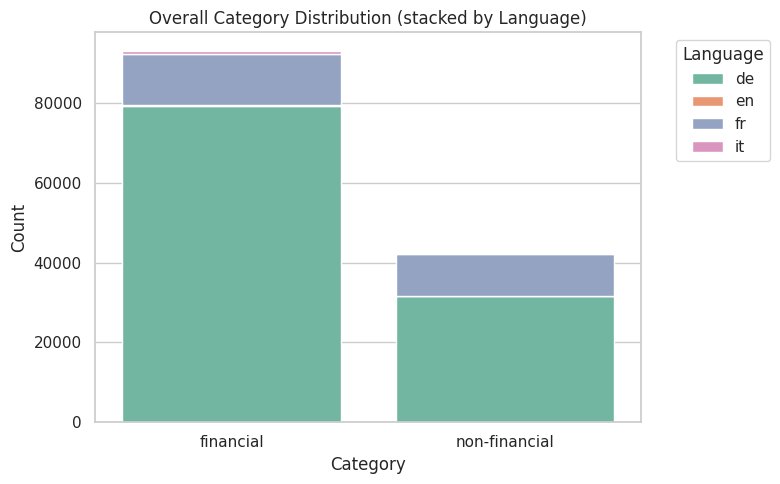

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# 1️⃣ Count combinations of category × language
counts = (
    df.groupby(["category", "language"])
      .size()
      .reset_index(name="count")
)

# 2️⃣ Pivot to wide format for stacking
pivot = counts.pivot(index="category", columns="language", values="count").fillna(0)

# 3️⃣ Plot stacked bars manually
plt.figure(figsize=(8,5))
bottom = None
for lang in pivot.columns:
    sns.barplot(
        x=pivot.index,
        y=pivot[lang],
        color=sns.color_palette("Set2")[list(pivot.columns).index(lang)],
        label=lang,
        bottom=bottom
    )
    if bottom is None:
        bottom = pivot[lang].copy()
    else:
        bottom += pivot[lang]

plt.title("Overall Category Distribution (stacked by Language)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()





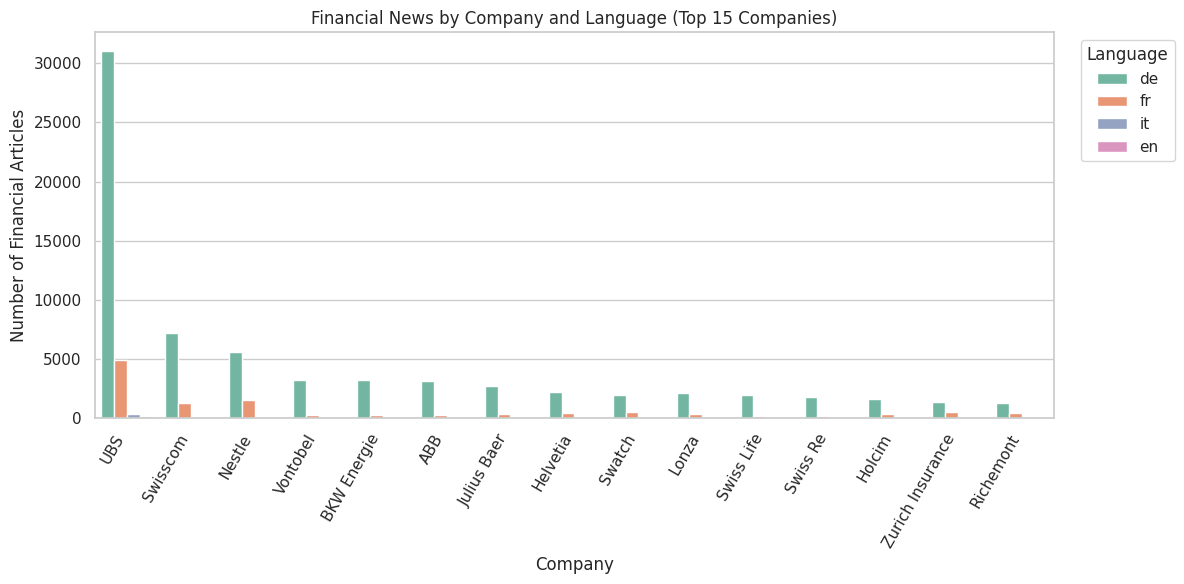

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# 1️⃣ Filter only financial articles
fin = df[df["category"].str.lower() == "financial"].copy()

# 2️⃣ Take top companies (you can adjust number if too many)
top_companies = fin["company"].value_counts().head(15).index
sub = fin[fin["company"].isin(top_companies)]

# 3️⃣ Plot
plt.figure(figsize=(12,6))
sns.countplot(
    data=sub,
    x="company",
    hue="language",          # ← hue = language
    order=top_companies,
    palette="Set2"
)

plt.title("Financial News by Company and Language (Top 15 Companies)")
plt.xlabel("Company")
plt.ylabel("Number of Financial Articles")
plt.xticks(rotation=60, ha="right")
plt.legend(title="Language", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1245121892.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  is_de  = df["language"].astype(str).str.lower().str.contains(r"^(de($|-)|ger|german)")
/tmp/ipython-input-1245121892.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fin_de["month"] = fin_de["pubtime"].dt.to_period("M").dt.to_timestamp()


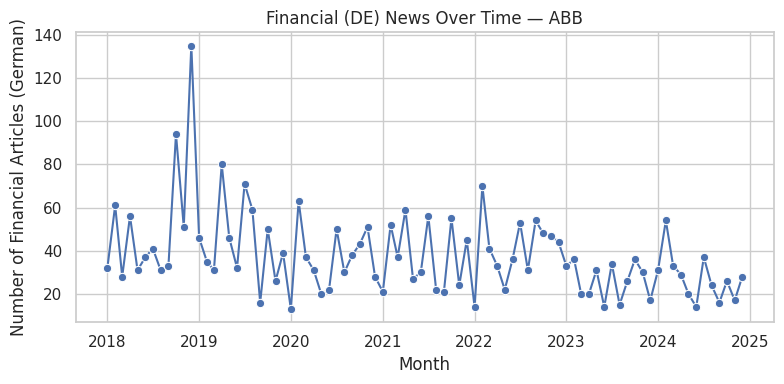

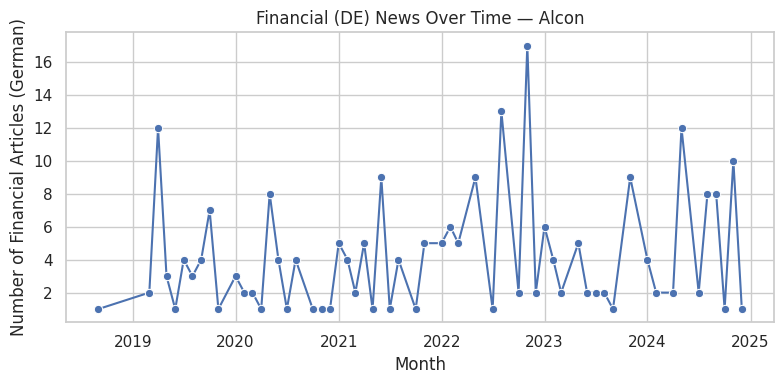

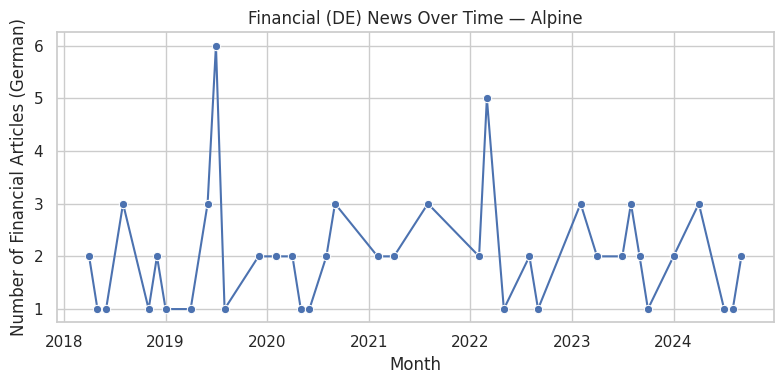

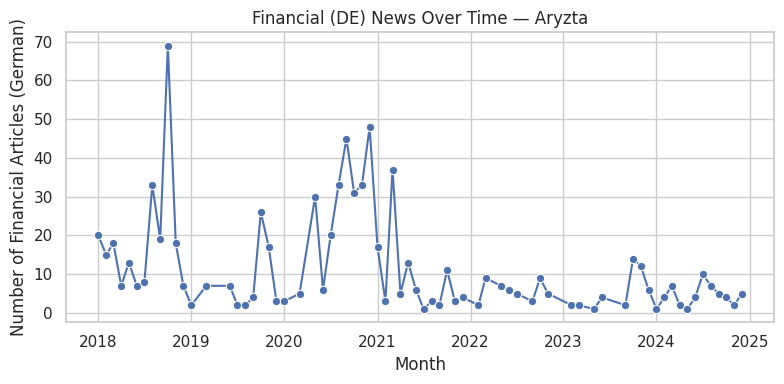

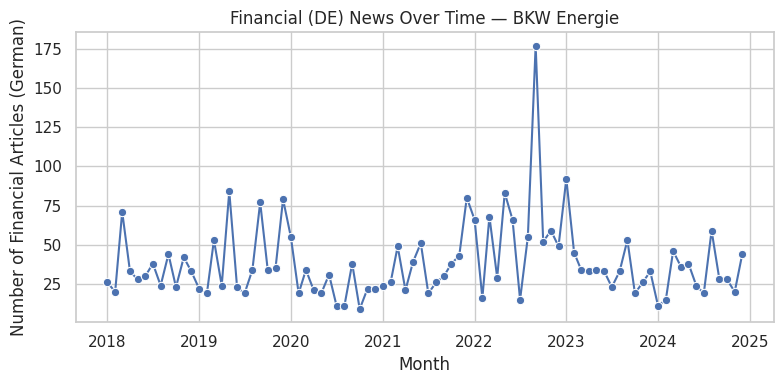

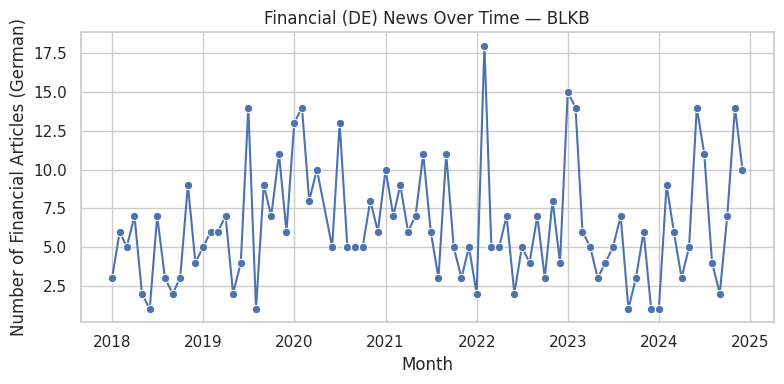

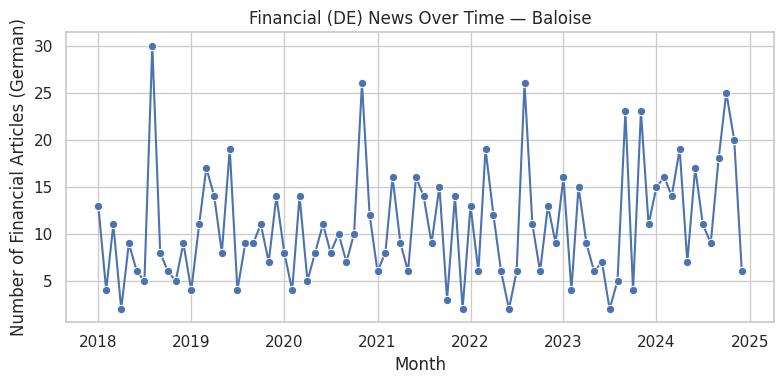

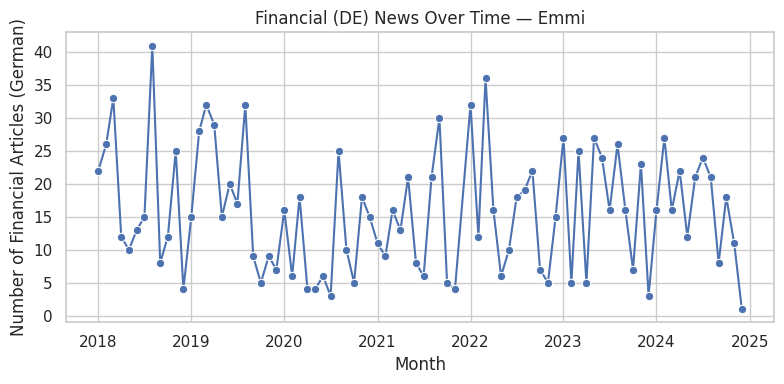

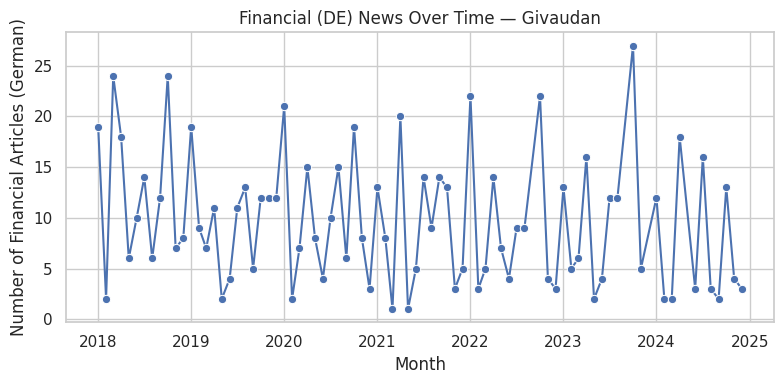

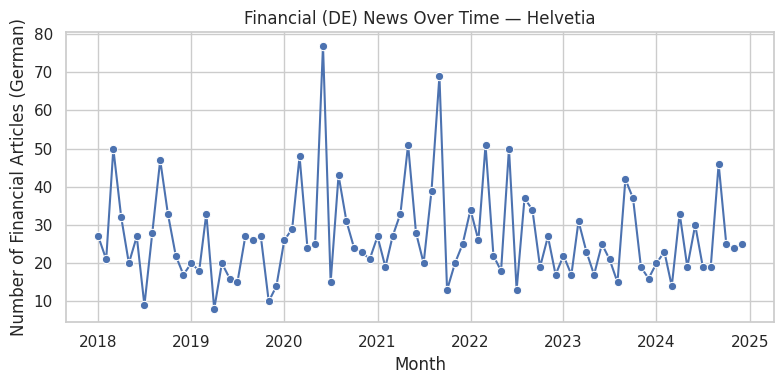

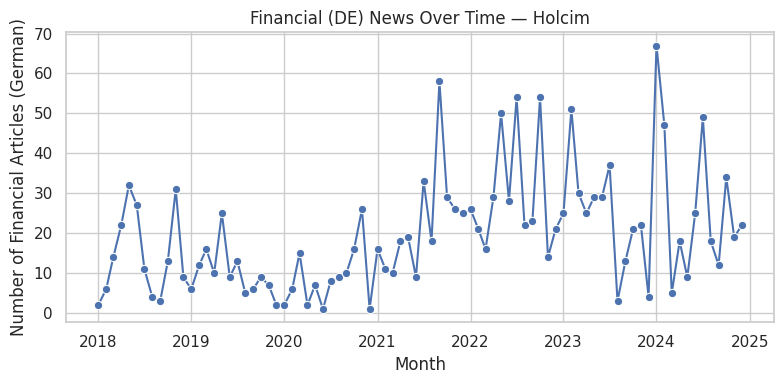

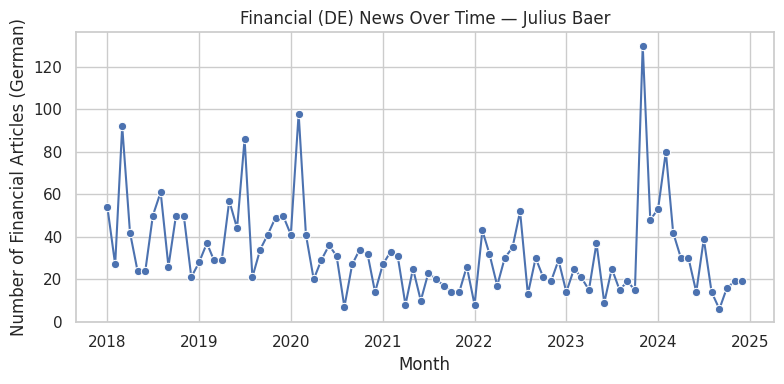

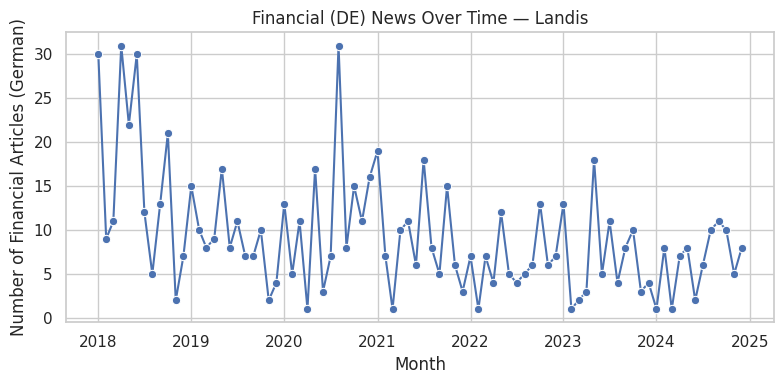

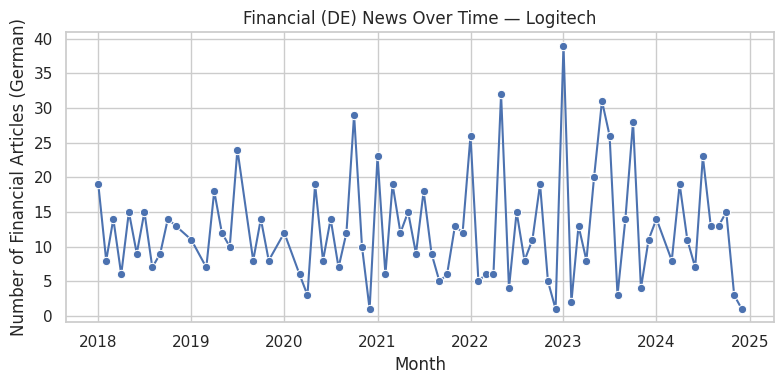

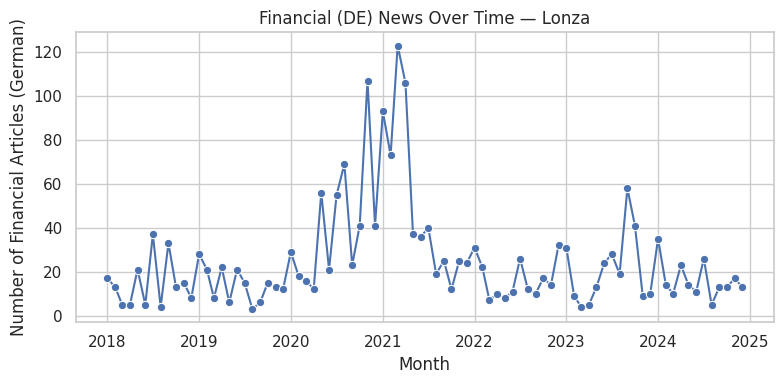

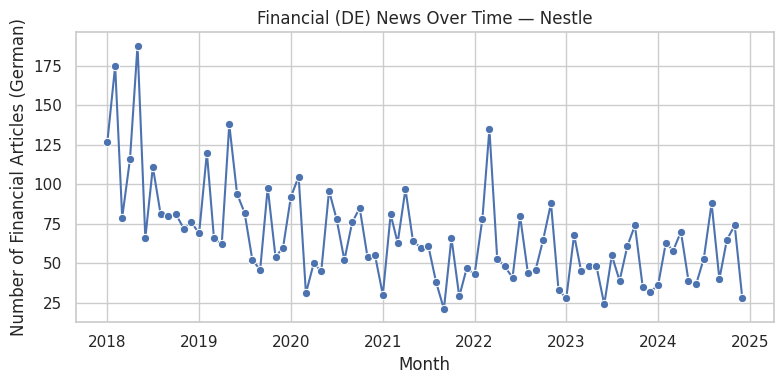

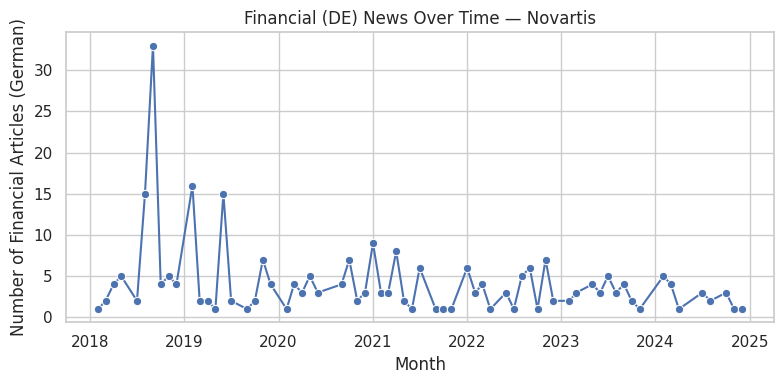

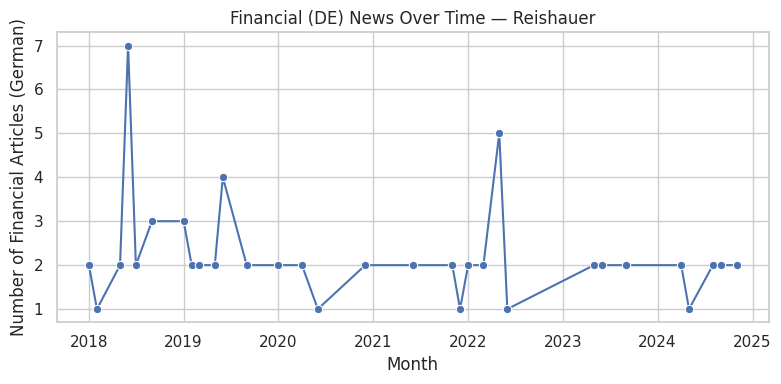

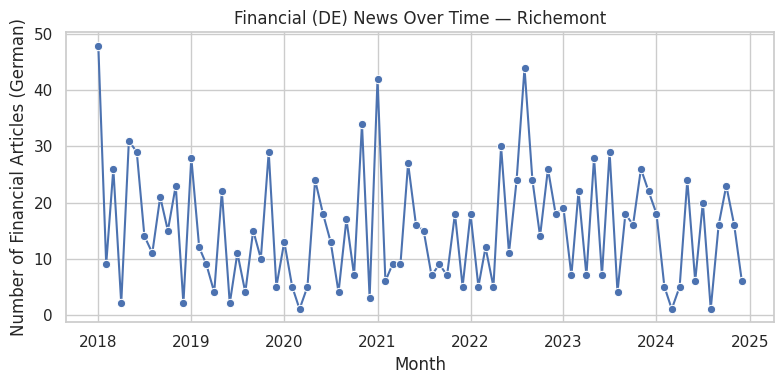

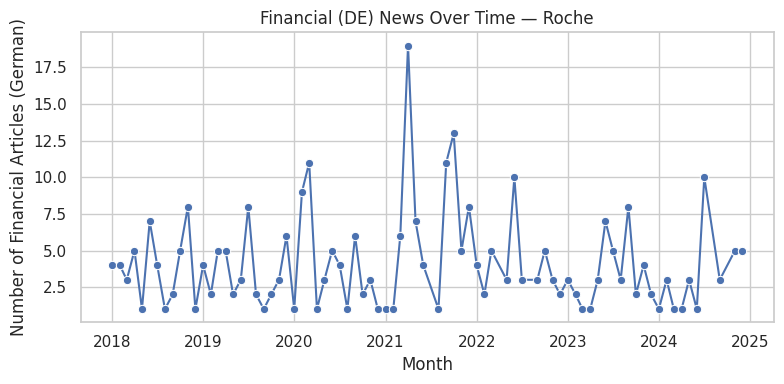

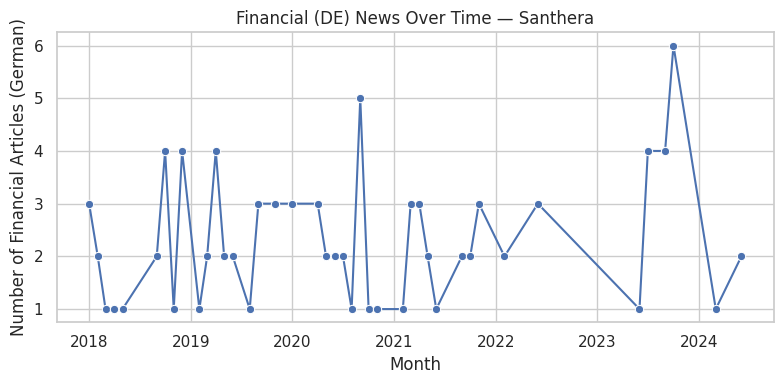

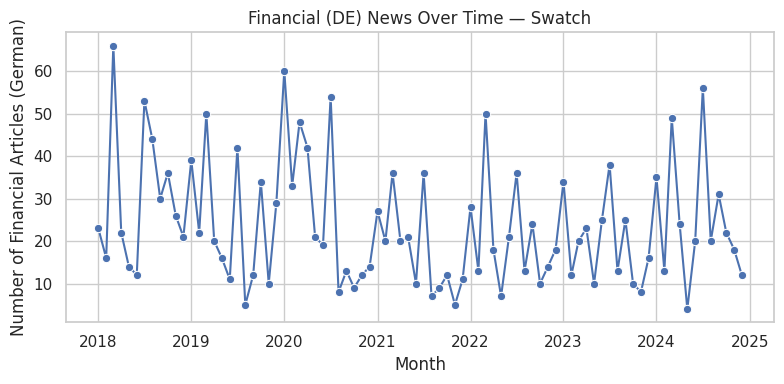

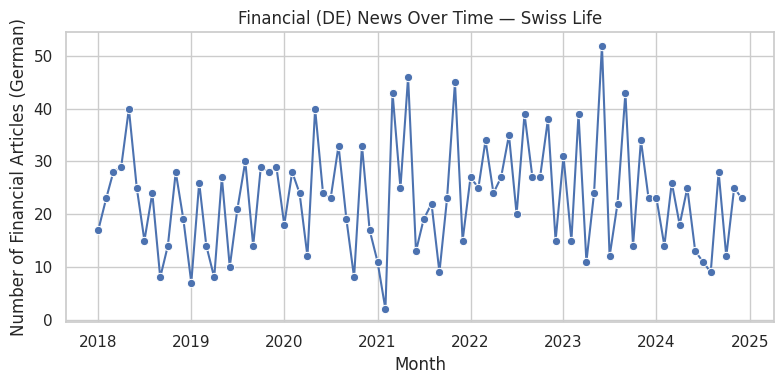

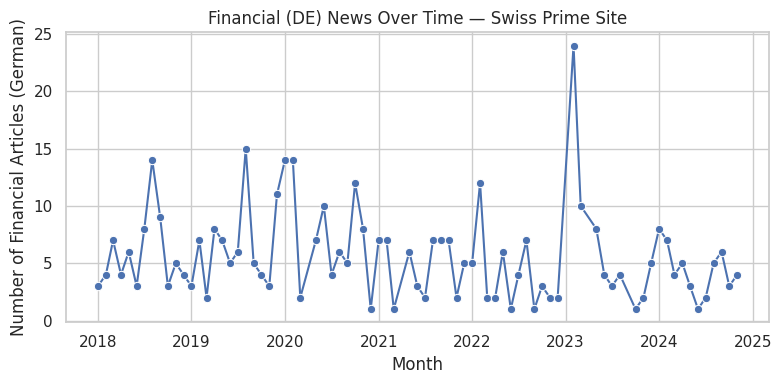

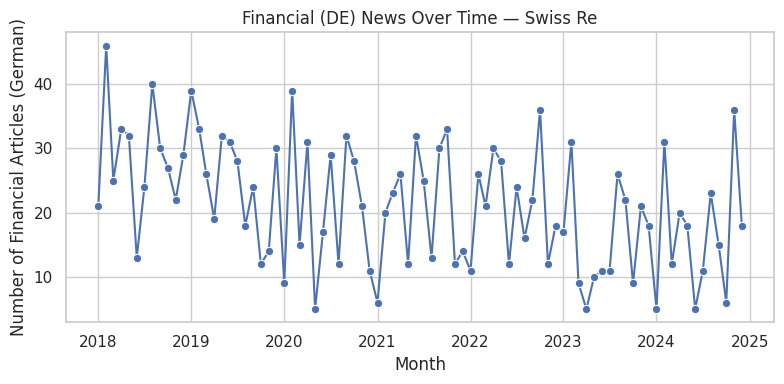

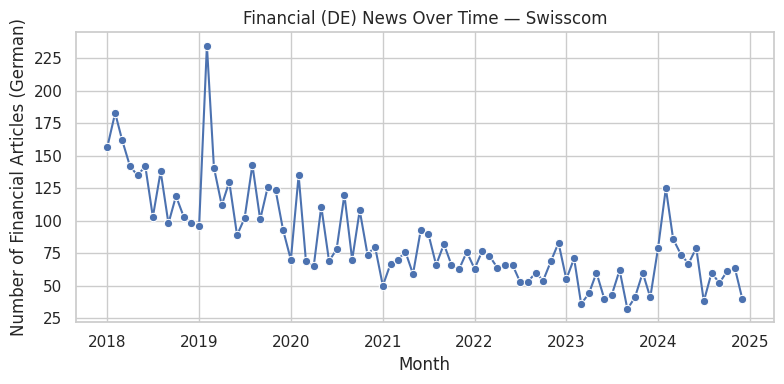

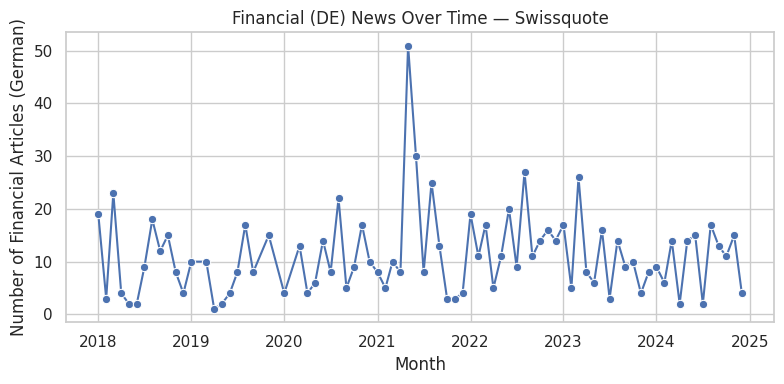

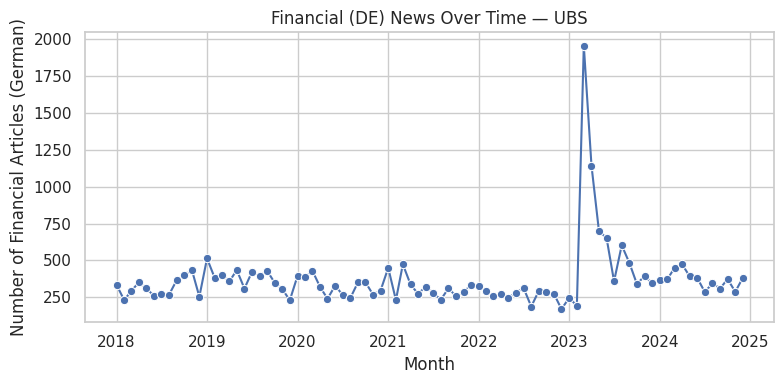

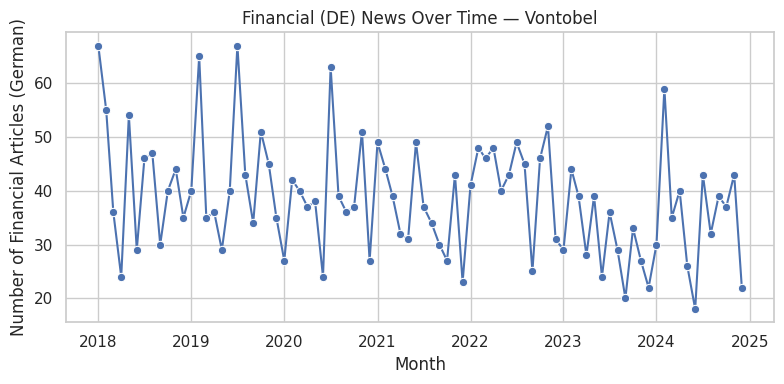

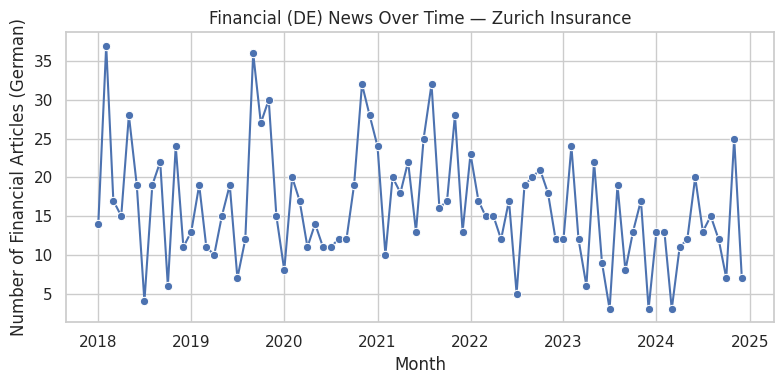

✅ Plots saved in folder: /content/drive/MyDrive/Colab Notebooks/plots_financial_each_company_DE


In [27]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

sns.set_theme(style="whitegrid")

# 1) Ensure datetime
df["pubtime"] = pd.to_datetime(df["pubtime"], errors="coerce")

# 2) Filter: financial + German language
is_fin = df["category"].astype(str).str.lower().eq("financial")
is_de  = df["language"].astype(str).str.lower().str.contains(r"^(de($|-)|ger|german)")
fin_de = df[is_fin & is_de].copy()

# 3) Monthly bucket
fin_de["month"] = fin_de["pubtime"].dt.to_period("M").dt.to_timestamp()

# 4) Output folder
out_dir = "/content/drive/MyDrive/Colab Notebooks/plots_financial_each_company_DE"
os.makedirs(out_dir, exist_ok=True)

# 5) Iterate per company and plot
for comp, sub in fin_de.groupby("company"):
    # monthly counts
    ts = (
        sub.groupby("month")
           .size()
           .reset_index(name="count")
           .sort_values("month")
    )
    if ts.empty or len(ts) < 2:
        continue  # skip if not enough points to plot a line

    plt.figure(figsize=(8,4))
    sns.lineplot(data=ts, x="month", y="count", marker="o")
    plt.title(f"Financial (DE) News Over Time — {comp}")
    plt.xlabel("Month")
    plt.ylabel("Number of Financial Articles (German)")
    plt.tight_layout()

    # safe filename (replace spaces/slashes)
    safe_comp = re.sub(r"[\\/*?:\"<>|]", "_", str(comp)).replace(" ", "_")
    fname = f"{out_dir}/{safe_comp}_financial_DE.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

print(f"✅ Plots saved in folder: {out_dir}")



/tmp/ipython-input-1294680032.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fin["year_month"] = fin["pubtime"].dt.to_period("M").astype(str)


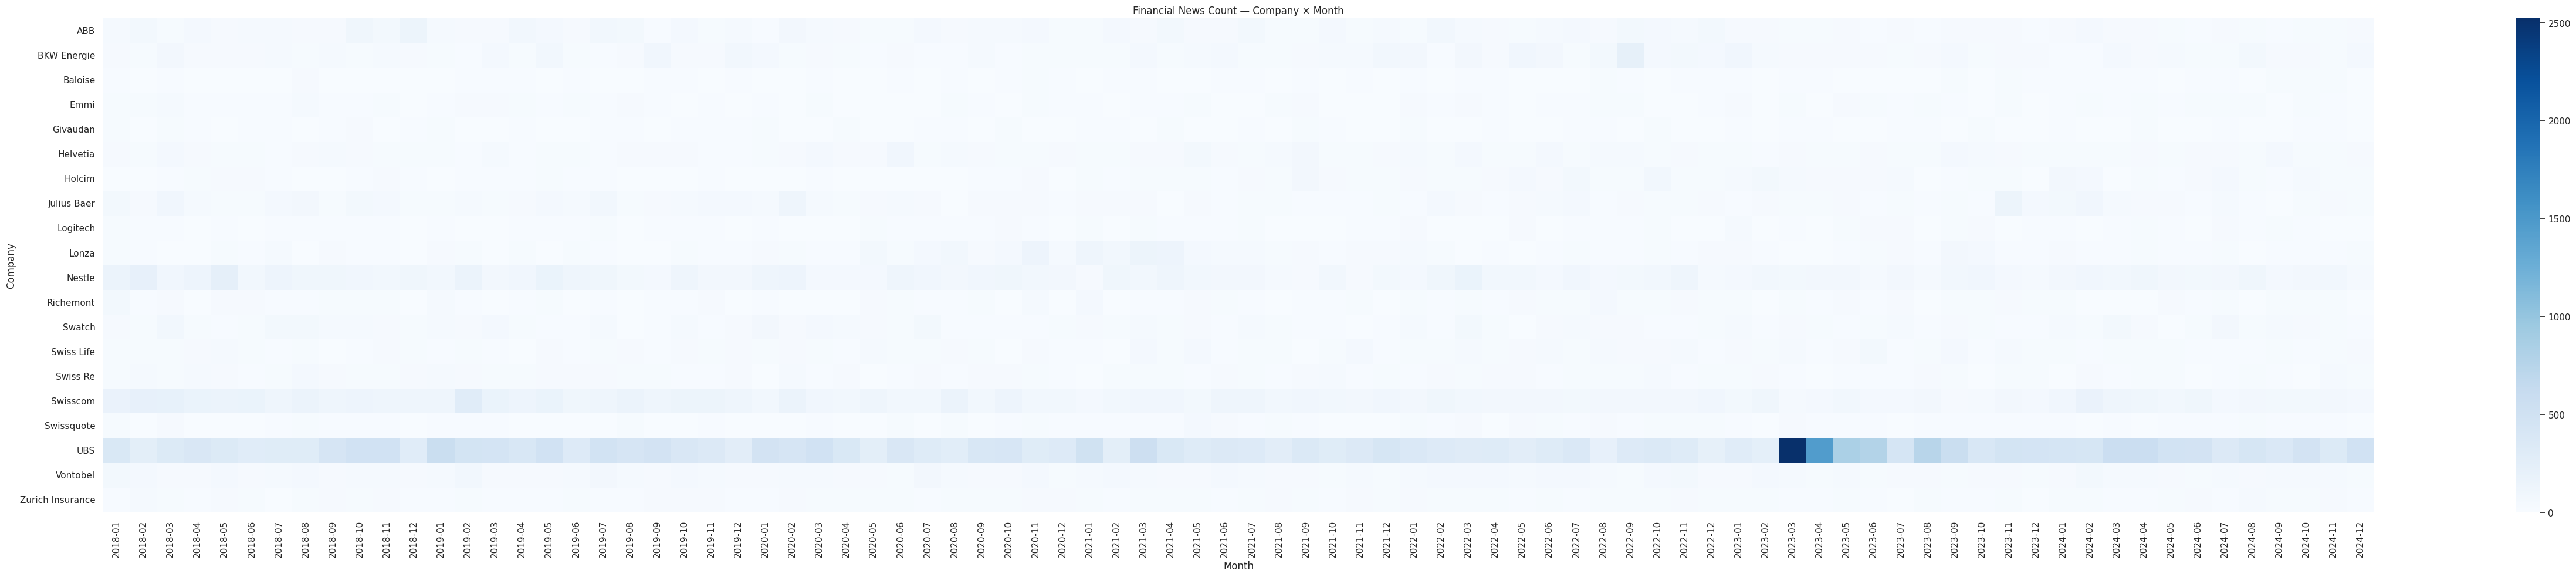

Saved -> financial_heatmap_company_month.csv


In [30]:
fin["pubtime"] = pd.to_datetime(fin["pubtime"], errors="coerce")
fin["year_month"] = fin["pubtime"].dt.to_period("M").astype(str)
TOP_N = 20
top_companies = fin["company"].value_counts().head(TOP_N).index
heat = (fin[fin["company"].isin(top_companies)]
        .pivot_table(index="company", columns="year_month",
                     values="category", aggfunc="count", fill_value=0))

plt.figure(figsize=(max(8,0.6*heat.shape[1]), 0.4*heat.shape[0]+2))
sns.heatmap(heat, cmap="Blues")
plt.title("Financial News Count — Company × Month")
plt.xlabel("Month"); plt.ylabel("Company")
plt.tight_layout(); plt.show()

heat.to_csv("/content/drive/MyDrive/Colab Notebooks/financial_heatmap_company_month.csv")
print("Saved -> financial_heatmap_company_month.csv")

/tmp/ipython-input-2837325103.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["category"]


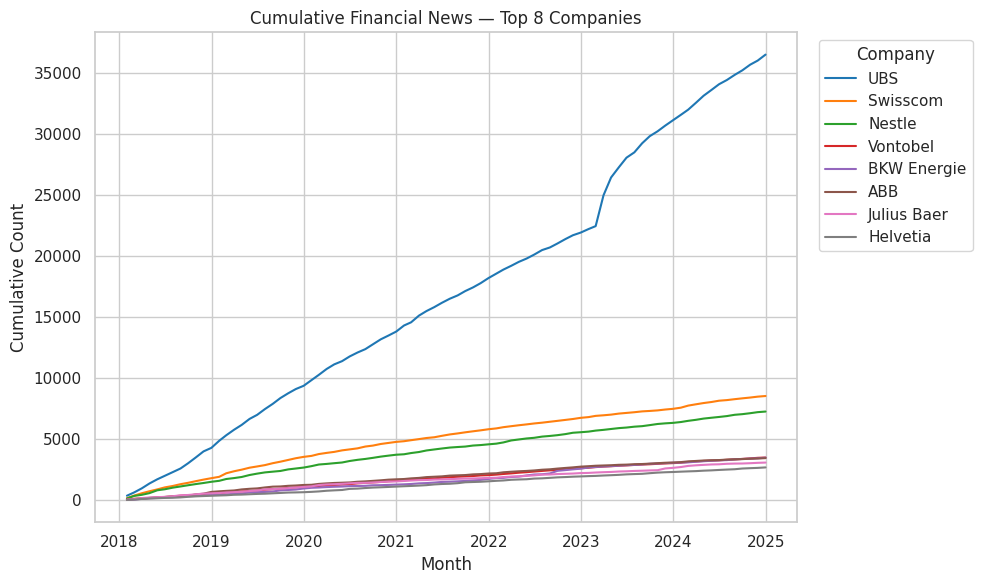

In [31]:
from itertools import cycle

top_fin = fin["company"].value_counts().head(8).index
plt.figure(figsize=(10,6))
palette = cycle(sns.color_palette("tab10"))

for comp, color in zip(top_fin, palette):
    ts = (fin[fin["company"]==comp]
          .set_index("pubtime")
          .resample("M")["category"]
          .count()
          .cumsum())
    plt.plot(ts.index, ts.values, label=comp, color=color)

plt.title("Cumulative Financial News — Top 8 Companies")
plt.xlabel("Month"); plt.ylabel("Cumulative Count")
plt.legend(title="Company", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()
